<a href="https://colab.research.google.com/github/JoseArthurSoares/fracture_detection_torch_faster_rcnn/blob/main/grupo_4_fracture_detection_torch_faster_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
from torch import nn
import albumentations as A
# import torchsummary
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

torch.cuda.empty_cache()

BS=16
LR=0.00005
epochs=20
IS=256
D='cuda' if torch.cuda.is_available() else 'cpu'

num_classes = 7
classes=['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']
c2l={k:v for k,v in list(zip(classes,list(range(num_classes))))}
l2c={v:k for k,v in c2l.items()}

dir_path='/content/input/bone-fracture-detection-computer-vision-project'
train_dir_path='/content/input/bone-fracture-detection-computer-vision-project/train'
train_img_paths = sorted(os.listdir('/content/input/bone-fracture-detection-computer-vision-project/train/images'))
train_target_paths = sorted(os.listdir('/content/input/bone-fracture-detection-computer-vision-project/train/labels'))

val_dir_path='/content/input/bone-fracture-detection-computer-vision-project/valid'
val_img_paths = sorted(os.listdir('/content/input/bone-fracture-detection-computer-vision-project/valid/images'))
val_target_paths = sorted(os.listdir('/content/input/bone-fracture-detection-computer-vision-project/valid/labels'))

In [ ]:
def unconvert(width, height, x, y, w, h):

    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)

    return xmin, ymin, xmax, ymax

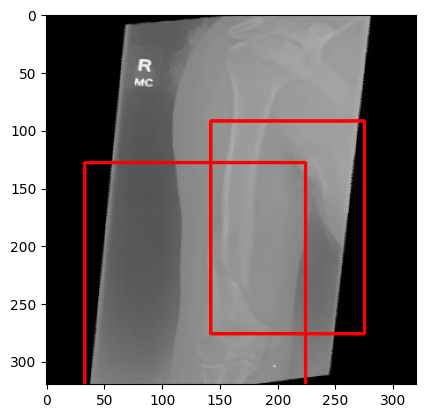

In [ ]:
idx=random.randint(0,3000)
# idx=0
ip=os.path.join(train_dir_path,'images',train_img_paths[idx])
tp=os.path.join(train_dir_path,'labels',train_target_paths[idx])

image=cv2.imread(ip)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image=cv2.resize(image,(320,320))

file=open(tp,'r')
target=list(map(float,file.read().split()))[1:]

a=0
while a<len(target):
    bbox=target[a:a+4]
    if len(bbox)==4:
        x,y,w,h=bbox[0], bbox[1], bbox[2], bbox[3]
        xmin,ymin,xmax,ymax=unconvert(320,320,x,y,w,h)
        sp,ep=(xmin,ymin),(xmax,ymax)
        image=cv2.rectangle(image,sp,ep,(255,0,0),2)
    a+=4

plt.imshow(image)
plt.show()

In [ ]:
augs=A.Compose([
    A.Resize(IS,IS),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']), is_check_shapes=True)

In [ ]:
class FractureData(torch.utils.data.Dataset):

    def __init__(self, dir_path, img_paths, target_paths, augs=None):
        self.dir_path=dir_path
        self.img_paths=img_paths
        self.target_paths=target_paths
        self.augs=augs

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self,idx):
        ip=os.path.join(self.dir_path,'images',self.img_paths[idx])
        tp=os.path.join(self.dir_path,'labels',self.target_paths[idx])

        image=cv2.imread(ip)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        H,W,_=image.shape

        file=open(tp,'r')
        target=list(map(float,file.read().split()))

        try:
            label=[target.pop(0)]
            bbox=[]
            i=0
            while i<len(target):
                x,y,w,h=target[i:i+4]
                bbox.append([*unconvert(W,H,x,y,w,h)])
                i+=4
            label=label*len(bbox)

            if self.augs!=None:
                data=self.augs(image=image,bboxes=bbox,class_labels=['None']*len(label))
                image=data['image']
                bbox=data['bboxes']
        except:
            if idx+1<len(self.img_paths):
                return self.__getitem__(idx+1)
            else:
                return self.__getitem__(0)

        image=torch.Tensor(np.transpose(image,(2,0,1)))/255.0
        bbox=torch.Tensor(bbox).long()
        label=torch.Tensor(label).long()

        annot={'boxes':bbox,'labels':label}

        return image, annot

    def collate_fn(self,batch):
        return tuple(zip(*batch))

In [ ]:
trainset=FractureData(train_dir_path, train_img_paths, train_target_paths, augs)
valset=FractureData(val_dir_path, val_img_paths, val_target_paths, augs)

trainloader=torch.utils.data.DataLoader(trainset,batch_size=BS,collate_fn=trainset.collate_fn)
valloader=torch.utils.data.DataLoader(valset,batch_size=BS,collate_fn=valset.collate_fn)

print(f'Training Data:- {len(trainset)} images divided into {len(trainloader)} batches')

Training Data:- 3631 images divided into 227 batches


In [ ]:
for image,target in trainloader:
    break

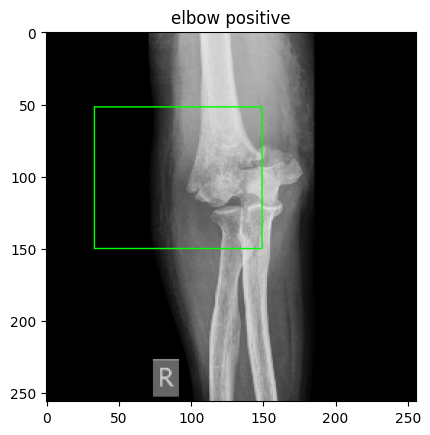

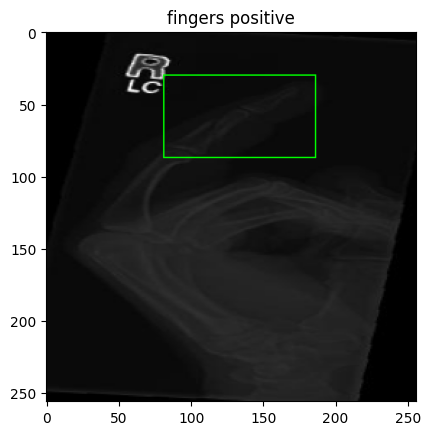

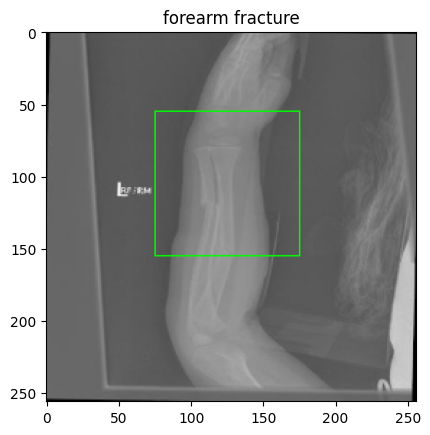

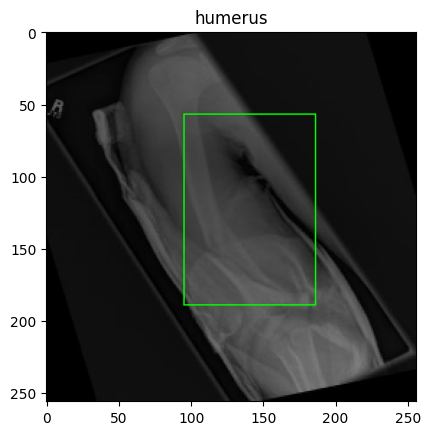

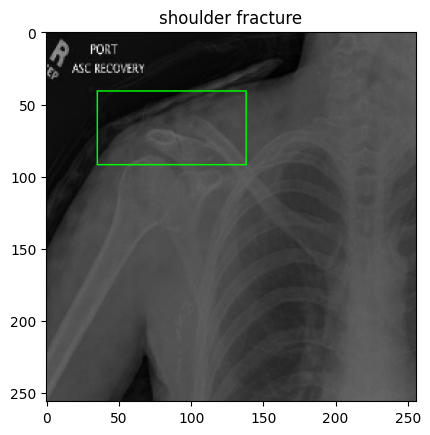

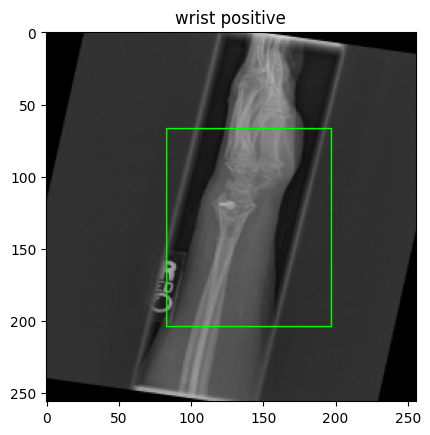

In [ ]:
def load_image_and_target(image_path, label_path):
    # Carrega a imagem
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IS, IS))

    # Carrega os rótulos
    with open(label_path, 'r') as file:
        target = list(map(float, file.read().split()))

    boxes = []
    labels = []
    for i in range(0, len(target), 5):
        if i + 4 < len(target):  # Garantir que há dados suficientes para uma caixa delimitadora
            label = int(target[i])
            x_center, y_center, width, height = target[i+1:i+5]
            x_min = (x_center - width / 2) * IS
            y_min = (y_center - height / 2) * IS
            x_max = (x_center + width / 2) * IS
            y_max = (y_center + height / 2) * IS
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(label)

    return image, {'boxes': torch.tensor(boxes), 'labels': torch.tensor(labels)}

# Função para mostrar uma imagem contendo a classe especificada
def show_image_with_class(image_paths, target_paths, l2c, class_id):
    for img_path, lbl_path in zip(image_paths, target_paths):
        img, tar = load_image_and_target(os.path.join(train_dir_path, 'images', img_path), os.path.join(train_dir_path, 'labels', lbl_path))
        if class_id in tar['labels'].tolist():
            for i, label in enumerate(tar['labels']):
                if label.item() == class_id:
                    bbox = tar['boxes'][i]
                    xmin, ymin, xmax, ymax = int(bbox[0].item()), int(bbox[1].item()), int(bbox[2].item()), int(bbox[3].item())
                    sp, ep = (xmin, ymin), (xmax, ymax)
                    cv2.rectangle(img, sp, ep, (0, 255, 0), 1)

            plt.imshow(img)
            plt.title(l2c[class_id])
            plt.show()
            break

# Mostrar uma imagem para cada classe
for class_id in range(num_classes):
    show_image_with_class(train_img_paths, train_target_paths, l2c, class_id)

#### Model

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model=torchvision.models.detection.fasterrcnn_resnet50_fpn(preTrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(D);

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 88.8MB/s]


In [ ]:
def trainarc(model, dataloader, opt):
    model.train()
    train_loss=0.0

    for images, targets in tqdm(dataloader):
        image=[i.to(D) for i in images]
        target=[{k:v.to(D) for k,v in ele.items()} for ele in targets]

        opt.zero_grad()
        losses=model(image,target)
        loss=sum(loss for loss in losses.values())
        loss.backward()
        opt.step()

        train_loss+=loss
    return train_loss/len(dataloader)

def evalarc(model, dataloader):
    model.train()
    val_loss=0.0
    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            image=[i.to(D) for i in images]
            target=[{k:v.to(D) for k,v in ele.items()} for ele in targets]

            losses=model(image,target)
            loss=sum( loss for loss in losses.values() )

            val_loss+=loss
    return val_loss/len(dataloader)

In [ ]:
best_val_loss=np.Inf

opt=torch.optim.Adam(model.parameters(),lr=LR)

for i in range(epochs):
    train_loss=trainarc(model,trainloader,opt)
    val_loss=evalarc(model,valloader)

    print(f"Epochs: {i+1}/{epochs}:- Trainloss: {train_loss}, Valloss: {val_loss}")

    if val_loss<best_val_loss:
        torch.save(model.state_dict(),'/content/working/model.pt')
        print("Model Updated")
        best_val_loss=val_loss

torch.save(model.state_dict(),'/content/working/FullyTrainedModel.pt')
print("Fully Trained Model Saved")
print(f"Done. Best Val Loss: {best_val_loss}")

100%|██████████| 22/22 [00:30<00:00,  1.38s/it]


Epochs: 1/20:- Trainloss: 0.4091746211051941, Valloss: 0.39149922132492065
Model Updated


100%|██████████| 22/22 [00:30<00:00,  1.37s/it]


Epochs: 2/20:- Trainloss: 0.3747023344039917, Valloss: 0.3750559687614441
Model Updated


100%|██████████| 22/22 [00:30<00:00,  1.38s/it]


Epochs: 3/20:- Trainloss: 0.3610953688621521, Valloss: 0.37677106261253357


100%|██████████| 22/22 [00:30<00:00,  1.39s/it]


Epochs: 4/20:- Trainloss: 0.3557441532611847, Valloss: 0.35712042450904846
Model Updated


100%|██████████| 22/22 [00:30<00:00,  1.39s/it]


Epochs: 5/20:- Trainloss: 0.35214853286743164, Valloss: 0.3678898513317108


100%|██████████| 22/22 [00:30<00:00,  1.38s/it]


Epochs: 6/20:- Trainloss: 0.348566472530365, Valloss: 0.383931428194046


100%|██████████| 22/22 [00:30<00:00,  1.38s/it]


Epochs: 7/20:- Trainloss: 0.34834983944892883, Valloss: 0.3881717324256897


100%|██████████| 22/22 [00:30<00:00,  1.38s/it]


Epochs: 8/20:- Trainloss: 0.3347278833389282, Valloss: 0.3816589415073395


100%|██████████| 22/22 [00:30<00:00,  1.37s/it]


Epochs: 9/20:- Trainloss: 0.3305836021900177, Valloss: 0.3798866271972656


100%|██████████| 22/22 [00:30<00:00,  1.38s/it]


Epochs: 10/20:- Trainloss: 0.33834025263786316, Valloss: 0.36381766200065613


100%|██████████| 22/22 [00:30<00:00,  1.38s/it]


Epochs: 11/20:- Trainloss: 0.30883345007896423, Valloss: 0.36205780506134033


100%|██████████| 22/22 [00:30<00:00,  1.37s/it]


Epochs: 12/20:- Trainloss: 0.29286065697669983, Valloss: 0.3551158607006073
Model Updated


100%|██████████| 22/22 [00:29<00:00,  1.36s/it]


Epochs: 13/20:- Trainloss: 0.2902779281139374, Valloss: 0.37238040566444397


100%|██████████| 22/22 [00:30<00:00,  1.36s/it]


Epochs: 14/20:- Trainloss: 0.2816215455532074, Valloss: 0.3766985833644867


100%|██████████| 22/22 [00:29<00:00,  1.36s/it]


Epochs: 15/20:- Trainloss: 0.26570573449134827, Valloss: 0.3548819124698639
Model Updated


100%|██████████| 22/22 [00:30<00:00,  1.38s/it]


Epochs: 16/20:- Trainloss: 0.2598632276058197, Valloss: 0.3966192305088043


100%|██████████| 22/22 [00:30<00:00,  1.38s/it]


Epochs: 17/20:- Trainloss: 0.25685620307922363, Valloss: 0.42603346705436707


100%|██████████| 22/22 [00:30<00:00,  1.37s/it]


Epochs: 18/20:- Trainloss: 0.24612213671207428, Valloss: 0.39704617857933044


100%|██████████| 22/22 [00:30<00:00,  1.38s/it]


Epochs: 19/20:- Trainloss: 0.2426583468914032, Valloss: 0.4110237658023834


100%|██████████| 22/22 [00:30<00:00,  1.37s/it]


Epochs: 20/20:- Trainloss: 0.23612545430660248, Valloss: 0.4295724332332611
Fully Trained Model Saved
Done. Best Val Loss: 0.3548819124698639


In [ ]:
test_dir_path='/content/input/bone-fracture-detection-computer-vision-project/test'
test_img_paths = sorted(os.listdir('/content/input/bone-fracture-detection-computer-vision-project/test/images'))
test_target_paths = sorted(os.listdir('/content/input/bone-fracture-detection-computer-vision-project/test/labels'))

testset=FractureData(test_dir_path, test_img_paths, test_target_paths, augs)

25


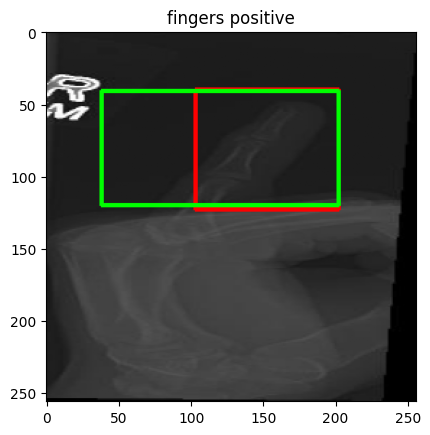

In [ ]:
idx=random.randint(0,len(testset)-1)
print(idx)
test_img,test_tar=testset[idx]

model.eval()
pred=model(test_img.unsqueeze(0).to(D))
# pred=torchvision.ops.nms(pred[0]['boxes'].detach(),pred[0]['scores'].detach(),0.02)
xmin,ymin,xmax,ymax=pred[0]['boxes'][0].detach().cpu().long().tolist()
label=pred[0]['labels'][0].item()

Txmin,Tymin,Txmax,Tymax=test_tar['boxes'][0].tolist()

image=cv2.rectangle(test_img.permute(1,2,0).numpy(),(xmin,ymin),(xmax,ymax),(255,0,0),2)
image=cv2.rectangle(image,(Txmin,Tymin),(Txmax,Tymax),(0,255,0),2)
plt.imshow(image)
plt.title(l2c[label])
plt.show()

100%|██████████| 22/22 [00:29<00:00,  1.34s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.1

                   precision    recall  f1-score  support
elbow positive      0.000000  0.000000  0.000000    102.0
fingers positive    0.218009  0.242105  0.229426    190.0
forearm fracture    0.102941  0.112903  0.107692    124.0
humerus fracture    0.000000  0.000000  0.000000      0.0
humerus             0.158621  0.239583  0.190871     96.0
shoulder fracture   0.147887  0.159091  0.153285    132.0
wrist positive      0.096774  0.115385  0.105263     52.0
micro avg           0.158046  0.158046  0.158046    696.0
macro avg           0.103462  0.124152  0.112363    696.0
weighted avg        0.135011  0.158046  0.145080    696.0


<ipython-input-20-52e76c35ba0d>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")


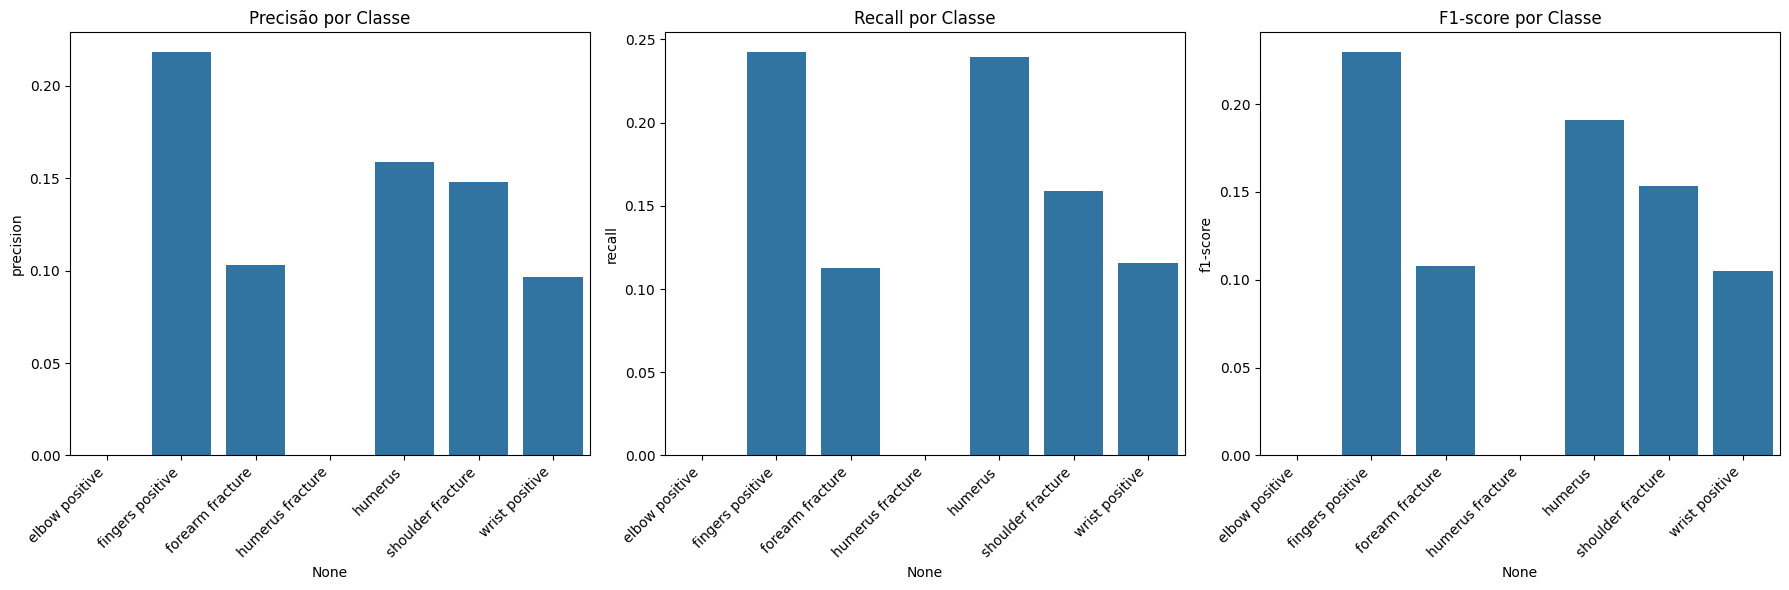

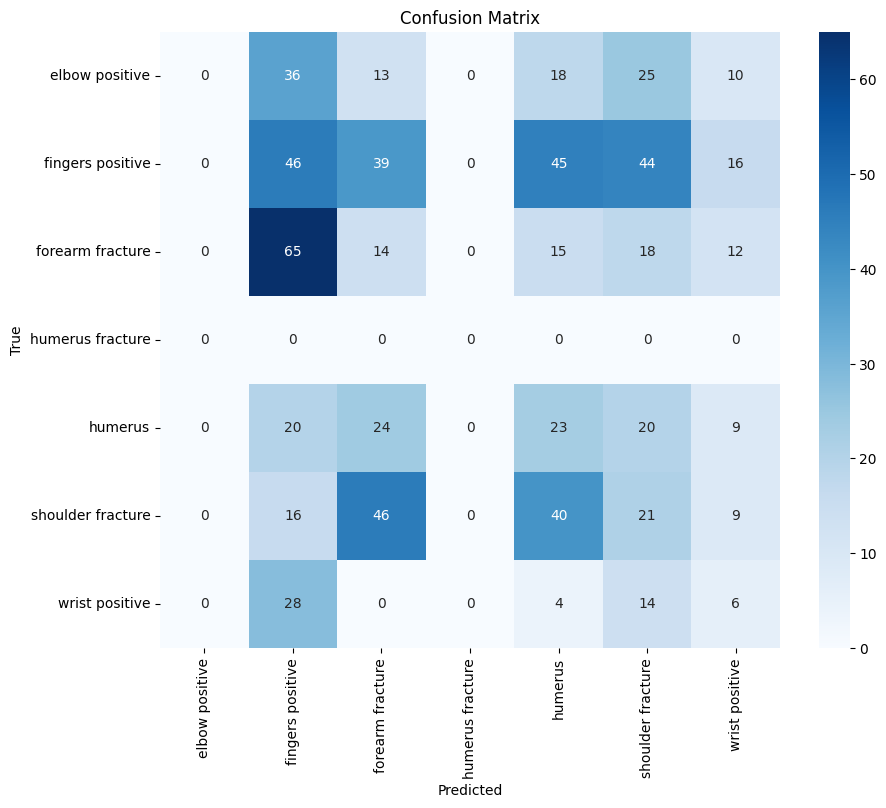

Accuracy: 0.1580
Mean Dice Coefficient: 0.4996


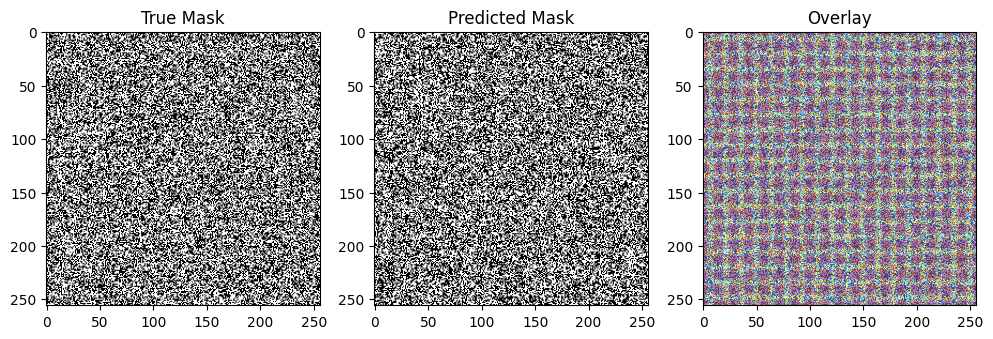

In [ ]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Função para calcular métricas
def evaluate_model(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            images = [img.to(D) for img in images]
            outputs = model(images)

            for i in range(len(outputs)):
                if 'labels' in targets[i]:
                    true_labels.extend(targets[i]['labels'].cpu().numpy())
                if 'labels' in outputs[i]:
                    pred_labels.extend(outputs[i]['labels'].cpu().numpy())
                else:
                    # Se não houver predições, adicionar um rótulo inválido (por exemplo, -1)
                    pred_labels.extend([-1] * len(targets[i]['labels']))

    return true_labels, pred_labels

# Calculando métricas no conjunto de validação
true_labels, pred_labels = evaluate_model(model, valloader)

# Ajustar o comprimento das listas para serem iguais, se necessário
min_len = min(len(true_labels), len(pred_labels))
true_labels = true_labels[:min_len]
pred_labels = pred_labels[:min_len]

# Gerando o relatório de classificação
# Especificando explicitamente os rótulos
labels = list(range(num_classes))
report = classification_report(true_labels, pred_labels, labels=labels, target_names=classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Exibindo a tabela de métricas
print(report_df)

# Plotando gráficos de barras para precisão, recall e F1-score
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precisão
sns.barplot(x=report_df.index[:-3], y=report_df['precision'][:-3], ax=axes[0])
axes[0].set_title('Precisão por Classe')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")

# Recall
sns.barplot(x=report_df.index[:-3], y=report_df['recall'][:-3], ax=axes[1])
axes[1].set_title('Recall por Classe')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

# F1-score
sns.barplot(x=report_df.index[:-3], y=report_df['f1-score'][:-3], ax=axes[2])
axes[2].set_title('F1-score por Classe')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(true_labels, pred_labels, labels=labels)

# Plotando a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculando e exibindo a acurácia
accuracy = accuracy_score(true_labels, pred_labels)
print(f'Accuracy: {accuracy:.4f}')

# Função para calcular o Dice Coefficient
def dice_coefficient(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection) / (y_true_f.sum() + y_pred_f.sum())

# Supondo que você tenha as segmentações verdadeiras e preditas como arrays numpy ou tensores do PyTorch
# y_true e y_pred devem ser arrays binários (0 e 1) para o cálculo do Dice Coefficient

# Exemplo:
# y_true = np.array([...])  # Carregue ou gere suas máscaras verdadeiras
# y_pred = np.array([...])  # Carregue ou gere suas máscaras preditas

# Aqui vamos criar exemplos fictícios para ilustrar
# Supondo que temos 10 imagens de tamanho 256x256
y_true = np.random.randint(0, 2, (10, 256, 256))
y_pred = np.random.randint(0, 2, (10, 256, 256))

# Calculando o Dice Coefficient para cada imagem
dice_scores = [dice_coefficient(y_true[i], y_pred[i]) for i in range(len(y_true))]
mean_dice = np.mean(dice_scores)
print(f'Mean Dice Coefficient: {mean_dice:.4f}')

# Visualizando exemplos de segmentação
idx = random.randint(0, len(y_true) - 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(y_true[idx], cmap='gray')
plt.title('True Mask')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[idx], cmap='gray')
plt.title('Predicted Mask')

plt.subplot(1, 3, 3)
plt.imshow(y_true[idx], cmap='gray', alpha=0.5)
plt.imshow(y_pred[idx], cmap='jet', alpha=0.5)
plt.title('Overlay')

plt.show()

In [ ]:
import os
import numpy as np

# Caminhos dos diretórios
train_label_dir = '/content/input/bone-fracture-detection-computer-vision-project/train/labels'
val_label_dir = '/content/input/bone-fracture-detection-computer-vision-project/valid/labels'
test_label_dir = '/content/input/bone-fracture-detection-computer-vision-project/test/labels'

# Classes e dicionários para contagem
classes = ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']
class_count = {cls: 0 for cls in classes}

# Função para contar as classes em um diretório de rótulos
def count_classes(label_dir):
    label_files = os.listdir(label_dir)
    local_class_count = {cls: 0 for cls in classes}

    for label_file in label_files:
        with open(os.path.join(label_dir, label_file), 'r') as file:
            lines = file.readlines()
            for line in lines:
                class_id = int(line.split()[0])
                class_name = classes[class_id]
                local_class_count[class_name] += 1
                class_count[class_name] += 1

    return local_class_count

# Contando as classes nos conjuntos de treinamento, validação e teste
train_class_count = count_classes(train_label_dir)
val_class_count = count_classes(val_label_dir)
test_class_count = count_classes(test_label_dir)

# Exibindo as contagens
print("Quantidade de imagens por classe no conjunto de treinamento:")
for cls, count in train_class_count.items():
    print(f"{cls}: {count}")

print("\nQuantidade de imagens por classe no conjunto de validação:")
for cls, count in val_class_count.items():
    print(f"{cls}: {count}")

print("\nQuantidade de imagens por classe no conjunto de teste:")
for cls, count in test_class_count.items():
    print(f"{cls}: {count}")

print("\nQuantidade total de imagens por classe:")
for cls, count in class_count.items():
    print(f"{cls}: {count}")


Quantidade de imagens por classe no conjunto de treinamento:
elbow positive: 339
fingers positive: 531
forearm fracture: 316
humerus fracture: 3
humerus: 311
shoulder fracture: 360
wrist positive: 228

Quantidade de imagens por classe no conjunto de validação:
elbow positive: 29
fingers positive: 48
forearm fracture: 43
humerus fracture: 0
humerus: 36
shoulder fracture: 20
wrist positive: 28

Quantidade de imagens por classe no conjunto de teste:
elbow positive: 17
fingers positive: 27
forearm fracture: 14
humerus fracture: 0
humerus: 15
shoulder fracture: 17
wrist positive: 6

Quantidade total de imagens por classe:
elbow positive: 385
fingers positive: 606
forearm fracture: 373
humerus fracture: 3
humerus: 362
shoulder fracture: 397
wrist positive: 262


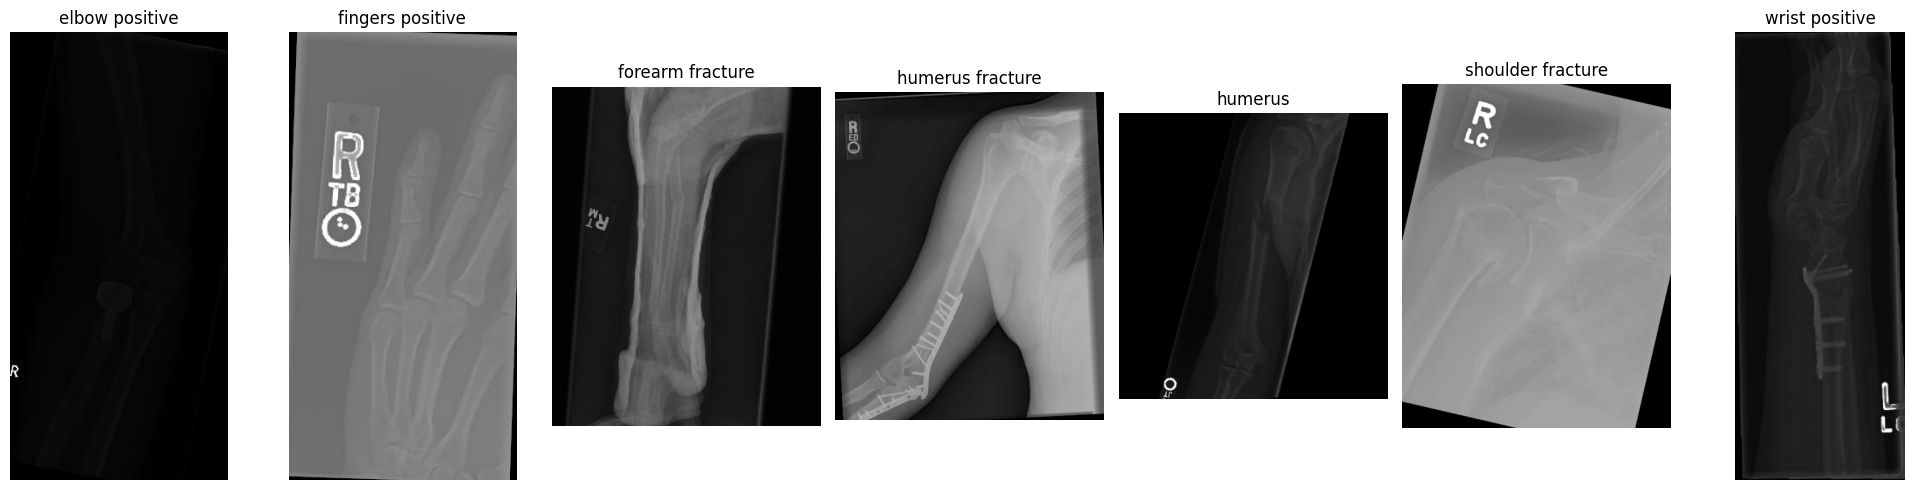

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

# Diretório das imagens e dos rótulos
train_img_dir = '/content/input/bone-fracture-detection-computer-vision-project/train/images'
train_label_dir = '/content/input/bone-fracture-detection-computer-vision-project/train/labels'

# Classes
classes = ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']
class_to_img = {cls: None for cls in classes}

# Função para ler rótulos e encontrar a primeira imagem de cada classe
def find_first_image_of_each_class(label_dir, img_dir):
    label_files = os.listdir(label_dir)

    for label_file in label_files:
        with open(os.path.join(label_dir, label_file), 'r') as file:
            lines = file.readlines()
            for line in lines:
                class_id = int(line.split()[0])
                class_name = classes[class_id]
                if class_to_img[class_name] is None:
                    img_file = label_file.replace('.txt', '.jpg')
                    img_path = os.path.join(img_dir, img_file)
                    if os.path.exists(img_path):
                        class_to_img[class_name] = img_path

                # Se todas as classes já tiverem uma imagem, podemos parar a busca
                if all(class_to_img.values()):
                    break
        if all(class_to_img.values()):
            break

# Encontrando as primeiras imagens de cada classe
find_first_image_of_each_class(train_label_dir, train_img_dir)

# Exibindo as imagens
fig, axes = plt.subplots(1, len(classes), figsize=(20, 5))

for ax, (cls, img_path) in zip(axes, class_to_img.items()):
    if img_path:
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.set_title(cls)
        ax.axis('off')

plt.tight_layout()
plt.show()
